# **YOLOv8 Training for UFDD dataset**

**Author:** [Yi-Jie Wong](https://www.linkedin.com/in/wongyijie/)<br>
**Date created:** 2023/07/19<br>
**Last modified:** 2023/09/15<br>
**Description:** Training YOLOv8 for UFDD Dataset + Conversion to OpenVINO

Reference
*   [How to use the Python API for YOLOv8](https://learnopencv.com/train-yolov8-on-custom-dataset/)
*   [How to use YOLOv5](https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb#scrollTo=zR9ZbuQCH7FX)
*   [yolo data format: x_c, y_c, w, h](https://github.com/ultralytics/yolov5/issues/2293#issuecomment-785534291)
*   [UFDD dataset](https://paperswithcode.com/dataset/ufdd)
*   [OpenVINO for YOLOv8](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/230-yolov8-optimization/230-yolov8-optimization.ipynb)



## **Get Ready UFDD dataset**

### Download UFDD dataset

Unconstrained Face Detection Dataset (UFDD) aims to fuel further research in unconstrained face detection.

<img src="https://production-media.paperswithcode.com/datasets/Screenshot_2021-02-01_at_16.05.53.png" alt="UFDD data example">

In [ ]:
from IPython.display import clear_output

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1aGR7FryrRuS86S9LBAqFksy-QDqsgBRV' -O "UFDD-annotationfile.zip"
!unzip "UFDD-annotationfile.zip"

clear_output()

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bZGzDx_CgNnxoRdLnmMLiZ3F9k5lnY4J' -O "UFDD_information.zip"
!unzip "UFDD_information.zip"

clear_output()

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o-lsXB7XLc4F39zQyZgwrabWyN1M5NBY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1o-lsXB7XLc4F39zQyZgwrabWyN1M5NBY" -O "UFDD_val.zip" && rm -rf /tmp/cookies.txt
!unzip "UFDD_val.zip"

clear_output()

In [ ]:
# remove the zip file
import os, shutil

for filename in os.listdir(os.getcwd()):
    if filename.endswith('.zip'):
        os.remove(filename)

### Get ready the dataset
1.   Split dataset
2.   Convert dataset into [appropriate format](https://github.com/ultralytics/yolov5/issues/2293#issuecomment-785534291)


#### 1. Split Dataset
For YOLOv5 and YOLOv8, you need to split your dataset following the directory structure below:
```
UFDD
├── train
│   └── images  
│   └── labels  
├── valid
│   └── images  
│   └── labels  
```
In this case, we created a folder called ```UFDD``` to store all data for UFDD dataset. All training data and validation data is stored in ```train``` and ```valid``` folder, respectively. ```images``` store all image for training/validation, while ```labels``` store all the labels for each image. Refer next part for the label format </br></br>



#### 2. Split Dataset
For each ```xxx.jpg``` (or other image format), you have a corresponding label file ```xxx.txt``` which follows the format below:

*   One row per object
*   Each row is ```class, x_center, y_center, width, height``` format.
*   Box coordinates must be in ```normalized xywh format (from 0 - 1)```. If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
*   Class numbers are zero-indexed (start from 0).

In [ ]:
data_dir = 'UFDD'

if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    os.mkdir(os.path.join(data_dir, 'train'))
    os.mkdir(os.path.join(data_dir, 'train', 'images'))
    os.mkdir(os.path.join(data_dir, 'train', 'labels'))

    os.mkdir(os.path.join(data_dir, 'valid'))
    os.mkdir(os.path.join(data_dir, 'valid', 'images'))
    os.mkdir(os.path.join(data_dir, 'valid', 'labels'))

In [ ]:
import matplotlib.pyplot as plt

filename = '/content/UFDD-annotationfile/UFDD_split/UFDD_val_bbx_gt.txt'
#filename = '/content/UFDD-annotationfile/UFDD_split/UFDD_val_bbx_gt-woDistractor.txt'

with open(filename, 'r') as file:
    # read lines
    lines = file.readlines()

    # loop all lines
    paths = []
    annots = []
    annot = []

    i = 0
    while i != len(lines):
        line = lines[i].replace('\n', '')
        path = os.path.join('/content/UFDD_val/images', line)
        if os.path.exists(path):
            # add path to paths
            paths.append(path)
            i += 1

            # load image
            img = plt.imread(path)
            try:
                y_shape, x_shape, _ = img.shape
            except:
                y_shape, x_shape = img.shape

            # next line is total object in this image
            count = int(lines[i].replace('\n', ''))
            i += 1

            # get all annot in this image
            for _ in range(count):
                # read next line
                line = lines[i].replace('\n', '')

                # split to x_start, y_start, x_range, y_range
                alist = line.split()
                alist = [int(item) for item in alist]
                x_start, y_start, x_range, y_range, _, _, _, _, _ = alist

                # normalize to 0 - 1
                x_start, x_range = x_start / x_shape, x_range / x_shape
                y_start, y_range = y_start / y_shape, y_range / y_shape

                # find x_c, y_c, w, h
                x_c = x_start + x_range/2
                y_c = y_start + y_range/2
                w = x_range
                h = y_range

                annot.append('0 {:.6f} {:.6f} {:.6f} {:.6f}'.format(x_c, y_c, w, h))
                i += 1

            # add annot to annots
            annots.append(annot)
            annot = []
        else:
            raise NotImplementedError

assert len(paths) == len(annots)

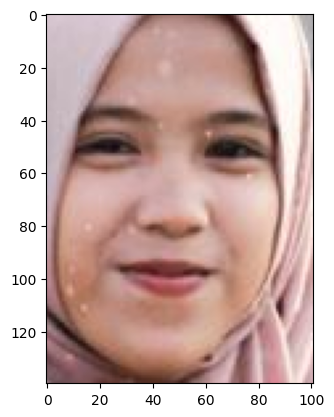

In [ ]:
# show that the format is correct

i = 0

# get image
img = plt.imread(paths[i])
y_shape, x_shape, _ = img.shape

annot = annots[i][0]
alist = annot.split()
alist = [float(item) for item in alist]
_, x_c, y_c, w, h = alist
x_c, w = x_c * x_shape, w * x_shape
y_c, h = y_c * y_shape, h * y_shape
y_start = int(y_c - h / 2)
x_start = int(x_c - w / 2)
y_range = int(h)
x_range = int(w)

img = img[y_start:int(y_start+y_range), x_start:int(x_start+x_range),:]
plt.imshow(img)

In [ ]:
# shuffle the data
import numpy as np

SEED = 123

np.random.seed(SEED)
np.random.shuffle(paths)
np.random.seed(SEED)
np.random.shuffle(annots)

In [ ]:
# split the data (in appropriate format)

TRAIN_RATIO = 0.8

for i, (path, annot) in enumerate(zip(paths, annots)):
    if i <= int(TRAIN_RATIO * len(paths)):
        image_dir = '/content/UFDD/train/images'
        label_dir = '/content/UFDD/train/labels'
    else:
        image_dir = '/content/UFDD/valid/images'
        label_dir = '/content/UFDD/valid/labels'

    # get path
    ori_image_path = paths[i]
    new_image_path = os.path.join(image_dir, os.path.basename(paths[i]))
    annot_path = os.path.join(label_dir, os.path.splitext(os.path.basename(new_image_path))[0]+'.txt')

    # copy image to new directory
    shutil.copyfile(ori_image_path, new_image_path)

    # save annotation as txt file
    with open(annot_path, 'w') as file:
        for item in annot:
            file.write(item + '\n')

In [ ]:
# get ready the yaml file for the dataset
yaml_config = [
    "train: '/content/UFDD/train'",
    "val: '/content/UFDD/valid'",
    "",
    "# class names",
    "names: ",
    "  0: 'face'"
]

# save annotation as txt file
yaml_file = 'UFDD.yaml'
with open(yaml_file, 'w') as file:
    for item in yaml_config:
        file.write(item + '\n')

## **YOLOv8 Training**

### Install ultralytics

In [ ]:
!pip install ultralytics==8.0.157

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 7.4 MB/s eta 0:00:00


In [ ]:
# !yolo task=detect \
# mode=predict \
# model=yolov8n.pt \
# conf=0.25 \
# source='https://media.roboflow.com/notebooks/examples/dog.jpeg'

### Training

In [ ]:
from ultralytics import YOLO

# Load the pretrained model
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 186MB/s]


In [ ]:
from ultralytics import YOLO

# Load the pretrained model
model = YOLO('yolov8n.pt')

# Training.
results = model.train(
   data=yaml_file,
   imgsz=640,
   epochs=100,
   batch=64,
   #amp=False,
   name='yolov8n_custom')

Ultralytics YOLOv8.0.158 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=UFDD.yaml, epochs=100, patience=50, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dyna

### Detect demo

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!yolo task=detect \
mode=predict \
model="/content/runs/detect/yolov8n_custom/weights/best.pt" \
source="/content/UFDD_val/images/haze/haze_02101.jpg" \
show=True \
imgsz=640 \
name=yolov8n_inference \
show_labels=False

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients

image 1/1 /content/UFDD_val/images/haze/haze_02101.jpg: 448x640 5 faces, 161.1ms
Speed: 14.7ms preprocess, 161.1ms inference, 146.9ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/yolov8n_inference


## **YOLOv5 Training**

### Install YOLOv5

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-196-gacdf73b Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.3/78.2 GB disk)


### Training

In [ ]:
# Train YOLOv5n
!python train.py --img 640 --batch 64 --epochs 1 --data "/content/UFDD.yaml" --weights yolov5n.pt #--cache

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5n.pt, cfg=, data=/content/UFDD.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, free

### Demo

In [ ]:
!python detect.py --weights "runs/train/exp3/weights/best.pt" --img 640 --conf 0.25 --source "/content/UFDD_val/images/haze/haze_02101.jpg"
# display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['runs/train/exp3/weights/best.pt'], source=/content/UFDD_val/images/haze/haze_02101.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=F

## **OpenVINO for YOLOv8**



### Install dependencies

In [ ]:
!pip install -q "openvino-dev>=2023.0.0" "nncf>=2.5.0"
!pip install -q "ultralytics==8.0.157" onnx

In [ ]:
from pathlib import Path

# Fetch the notebook utils script from the openvino_notebooks repo
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import download_file, VideoPlayer

### Utility function

In [ ]:
from typing import Tuple, Dict
import cv2
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import colors


def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, mask:np.ndarray = None, label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        mask (np.ndarray, *optional*, None): instance segmentation mask polygon in format [N, 2], where N - number of points in contour, if not provided, only box will be drawn
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    if mask is not None:
        image_with_mask = img.copy()
        mask
        cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
        img = cv2.addWeighted(img, 0.5, image_with_mask, 0.5, 1)
    return img


def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:

    """
    boxes = results["det"]
    masks = results.get("segment")
    h, w = source_image.shape[:2]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        mask = masks[idx] if masks is not None else None
        source_image = plot_one_box(xyxy, source_image, mask=mask, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



In [ ]:
from typing import Tuple
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input,
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints

    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size


    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]

    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0

    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

In [ ]:
try:
    scale_segments = ops.scale_segments
except AttributeError:
    scale_segments = ops.scale_coords

def postprocess(
    pred_boxes:np.ndarray,
    input_hw:Tuple[int, int],
    orig_img:np.ndarray,
    min_conf_threshold:float = 0.25,
    nms_iou_threshold:float = 0.7,
    agnosting_nms:bool = False,
    max_detections:int = 300,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False,
    number_of_class = 1
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
        pred_masks (np.ndarray, *optional*, None): model ooutput prediction masks, if not provided only boxes will be postprocessed
        retina_mask (bool, *optional*, False): retina mask postprocessing instead of native decoding
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label] and segment - segmentation polygons for each element in batch
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    # if pred_masks is not None:
    #     nms_kwargs["nm"] = 32
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=number_of_class,
        **nms_kwargs
    )
    results = []
    proto = torch.from_numpy(pred_masks) if pred_masks is not None else None

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        if proto is None:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append({"det": pred})
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        results.append({"det": pred[:, :6].numpy(), "segment": segments})
    return results

### Convert PyTorch YOLO model to OpenVINO IR

In [ ]:
# Sample image for demo
IMAGE_PATH = Path('/content/UFDD_val/images/haze/haze_02101.jpg')

# load the yolov8 model
from ultralytics import YOLO
import os

det_model = YOLO(f"/content/runs/detect/{experiment}/weights/best.pt")
'''
if you have pretrained yolo model using ultralytics==8.0.157
https://github.com/mikel-brostrom/yolo_tracking/issues/859
'''
# det_model = YOLO('/content/best.pt')

label_map = det_model.model.names

res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

# export model to openvino format (using prebuilt export function in yolov8)
det_model_path = f"/content/runs/detect/{experiment}/weights/best_openvino_model/best.xml"
if not os.path.isfile(det_model_path):
    det_model.export(format="openvino", dynamic=True, half=False)

'''
if you have pretrained yolo model using ultralytics==8.0.157
'''
# det_model_path='/content/best_openvino_model/best.xml'


image 1/1 /content/UFDD_val/images/haze/haze_02101.jpg: 448x640 5 faces, 15.4ms
Speed: 8.1ms preprocess, 15.4ms inference, 8.8ms postprocess per image at shape (1, 3, 448, 640)
Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from '/content/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success ✅ 1.5s, saved as '/content/best.onnx' (11.5 MB)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================




OpenVINO: starting export with openvino 2023.0.2-11065-e662b1a3301-releases/2023/0...
OpenVINO: export success ✅ 1.2s, saved as '/content/best_openvino_model/' (11.8 MB)

Export complete (5.3s)
Results saved to /content
Predict:         yolo predict task=detect model=/content/best_openvino_model imgsz=640 
Validate:        yolo val task=detect model=/content/best_openvino_model imgsz=640 data=UFDD.yaml 
Visualize:       https://netron.app


### verify model inference

In [ ]:
import ipywidgets as widgets
from openvino.runtime import Core

core = Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [ ]:
det_model_path

In [ ]:
device.value

'AUTO'

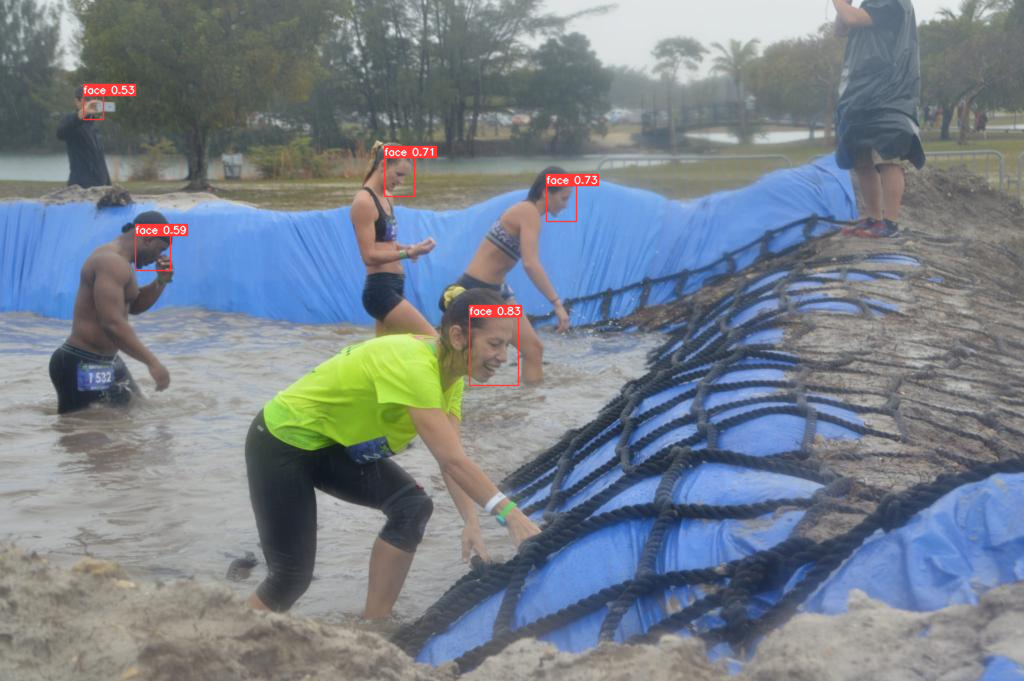

In [ ]:
from openvino.runtime import Core, Model

core = Core()
det_ov_model = core.read_model(det_model_path)
if device.value != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
det_compiled_model = core.compile_model(det_ov_model, device.value)


def detect(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    masks = None
    if num_outputs > 1:
        masks = result[model.output(1)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image, pred_masks=masks)
    return detections


input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

# **OpenVINO: Post Training Optimization**
Reference
*    [Object Detection Quantization](https://docs.openvino.ai/2022.2/notebooks/111-detection-quantization-with-output.html)

In [ ]:
from ultralytics.yolo.utils import DEFAULT_CFG
from ultralytics.yolo.cfg import get_cfg
from ultralytics.yolo.data.utils import check_det_dataset

CFG_PATH = 'UFDD.yaml'
args = get_cfg(cfg=DEFAULT_CFG)
args.data = str(CFG_PATH)

In [ ]:
det_model

In [ ]:
det_model = YOLO("/content/runs/detect/yolov8n_custom/weights/best.pt")

In [ ]:
det_validator = det_model.ValidatorClass(args=args)

AttributeError: ignored

In [ ]:
import nncf  # noqa: F811
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = det_validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

In [ ]:
from openvino.runtime import serialize
int8_model_det_path = f"/content/runs/detect/{experiment}/weights/best_openvino_model/best_int8.xml"
print(f"Quantized detection model will be saved to {int8_model_det_path}")
serialize(quantized_det_model, str(int8_model_det_path))

Quantized detection model will be saved to /content/runs/detect/yolov8n_custom/weights/best_openvino_model/best_int8.xml


NameError: ignored